In [15]:
import pandas as pd
import numpy as np
from tqdm import tqdm  
import cvxpy as cp
from scipy.stats import genpareto
import matplotlib.pyplot as plt
from scipy.optimize import minimize, LinearConstraint, NonlinearConstraint, Bounds

# 1. Representative's life insurance


In [2]:
# function to build asset allocation table 

def build_asset_table(asset_list, asset_weight, asset_total, asset_duration, asset_return):
    """
    Build an asset allocation table with market values, weights, durations, and expected returns.
    Checks that weights sum to 1.
    """

    # safety check: weights sum to 1 
    if not np.isclose(asset_weight.sum(), 1.0):
        raise ValueError(f"Asset weights must sum to 1. Current sum = {asset_weight.sum():.4f}")

    #  compute asset values 
    asset_value = asset_total * asset_weight

    #  compute weighted averages (for totals)
    weighted_duration = np.sum(asset_duration * asset_weight)
    weighted_return = np.sum(asset_return * asset_weight)

    #  assemble into DataFrame
    df = pd.DataFrame({
        "Asset": asset_list,
        "Market Value": asset_value,
        "Weight (%)": asset_weight * 100,
        "Modified Duration": asset_duration,
        "Expected Return (%)": asset_return * 100
    })

    #  append total row ---
    total_row = pd.DataFrame({
        "Asset": ["Total"],
        "Market Value": [asset_total],
        "Weight (%)": [100.0],
        "Modified Duration": [weighted_duration],
        "Expected Return (%)": [weighted_return * 100]
    })

    df = pd.concat([df, total_row], ignore_index=True)

    return df


In [17]:

# Example usage 

asset_list = ['gov_bond', 'corp_bond', 'equity_1', 'equity_2', 'property', 't_bills']
asset_total = 1652.7

asset_duration = pd.DataFrame(
    [5.2, 5.0, 0.0, 0.0, 0.0, 0.1],
    index=asset_list,
    columns=['Duration']
)

asset_return = np.array([0.029, 0.041, 0.064, 0.064, 0.056, 0.006])

# build the table

# Asset side
asset_list = ['gov_bond', 'corp_bond', 'equity_1', 'equity_2', 'property', 't_bills']
asset_value = np.array([782.6, 586, 0, 102.5, 42, 139.6])
asset_total = 1652.7

#  compute asset values
asset_weight = asset_value / asset_total

# Modified duration
asset_duration = np.array([5.2, 5, 0, 0, 0, 0.1])

# Annualized expected return
asset_return = np.array([0.029, 0.041, 0.064, 0.064, 0.056, 0.006])

# initial_asset = build_asset_table(asset_list, asset_weight, asset_total, asset_duration, asset_return)

# initial_asset

asset_duration


array([5.2, 5. , 0. , 0. , 0. , 0.1])

In [18]:
# Example usage 

# Initial Liabilities 

liab_value = [1424.2]
liab_duration = [6.6]

# Initila asset

asset_list = ['gov_bond', 'corp_bond', 'equity_1', 'equity_2', 'property', 't_bills']
asset_total = 1652.7

initial_asset = pd.DataFrame(index=asset_list)

initial_asset['asset_val'] = [782.6, 586, 0, 102.5, 42, 139.6]
initial_asset['asset_dur'] = [5.2, 5.0, 0.0, 0.0, 0.0, 0.1]
initial_asset['asset_ret'] = [0.029, 0.041, 0.064, 0.064, 0.056, 0.006]
initial_asset['asset_weight'] = initial_asset['asset_val']/initial_asset['asset_val'].sum()

initial_asset

,asset_val,asset_dur,asset_ret,asset_weight
gov_bond,782.6,5.2,0.029,0.473528
corp_bond,586.0,5.0,0.041,0.354571
equity_1,0.0,0.0,0.064,0.000000
equity_2,102.5,0.0,0.064,0.062020
property,42.0,0.0,0.056,0.025413
t_bills,139.6,0.1,0.006,0.084468


In [19]:
# Compute initial expected return

initial_asset['asset_ret']@initial_asset['asset_weight']

np.float64(0.03416893568100684)

In [20]:
# Solvency II params

int_up_param = 0.011
int_down_param = 0.009
equity_1_param = 0.39
equity_2_param = 0.49
prop_params = 0.25
spread_params = 0.103
rho = 0.75


Right now you are treating illiquid assets = corp + equities + property, but in the paper illiquid = equity_1 + equity_2 + property, and corporates have a separate 50% cap.

In [60]:
allocation_limits_data = {
    "asset": [
        "gov_bond",
        "illiquid_assets",
        "t_bills",
        "corp_bond",
    ],
    "description": [
        "Government Bonds",
        "Equities + Property (Illiquid)",
        "Treasury Bills",
        "Corporate Bonds",
    ],
    "min_weight": [
        0.25,   # gov min
        0.0,    # illiquid min
        0.01,   # t-bills min
        0.0,    # corp min
    ],
    "max_weight": [
        0.75,   # gov max
        0.20,   # illiquid max
        0.05,   # t-bills max
        0.50,   # corp max (as in the paper)
    ]
}

allocation_limits = pd.DataFrame(allocation_limits_data).set_index("asset")

allocation_limits

,description,min_weight,max_weight
asset,,,
gov_bond,Government Bonds,0.25,0.75
illiquid_assets,Equities + Property (Illiquid),0.00,0.20
t_bills,Treasury Bills,0.01,0.05
corp_bond,Corporate Bonds,0.00,0.50


In [22]:
allocation_limits["min_weight"].values * asset_total

array([413.175,   0.   ,  16.527])

In [23]:
# SCR Market Correlation Matrix (Interest Rate Downward Scenario) ---
corr_downward = pd.DataFrame(
    [
        [1.0, 0.5, 0.5, 0.5],
        [0.5, 1.0, 0.75, 0.75],
        [0.5, 0.75, 1.0, 0.5],
        [0.5, 0.75, 0.5, 1.0]
    ],
    index=["interest", "equity", "property", "spread"],
    columns=["interest", "equity", "property", "spread"]
)

# SCR Market Correlation Matrix (Interest Rate Upward Scenario) ---
corr_upward = pd.DataFrame(
    [
        [1.0, 0.0, 0.0, 0.0],
        [0.0, 1.0, 0.75, 0.75],
        [0.0, 0.75, 1.0, 0.5],
        [0.0, 0.75, 0.5, 1.0]
    ],
    index=["interest", "equity", "property", "spread"],
    columns=["interest", "equity", "property", "spread"]
)

corr_upward

corr_upward

,interest,equity,property,spread
interest,1.0,0.00,0.00,0.00
equity,0.0,1.00,0.75,0.75
property,0.0,0.75,1.00,0.50
spread,0.0,0.75,0.50,1.00


In [24]:
def scr_interest_rate(A, D_A, L, D_L, delta_y_down, delta_y_up):
    """
    Compute Solvency II interest rate risk SCR (formula (1)) directly.
    
    Parameters
    ----------
    A : array-like
        Market values of interest-sensitive assets
    D_A : array-like
        Modified durations of assets
    L : array-like
        Market values of liabilities
    D_L : array-like
        Modified durations of liabilities
    delta_y_down : float
        Downward rate shock magnitude (positive number, e.g. 0.009)
    delta_y_up : float
        Upward rate shock magnitude (positive number, e.g. 0.011)
    """

    A = np.array(A, dtype=float)
    D_A = np.array(D_A, dtype=float)
    L = np.array(L, dtype=float)
    D_L = np.array(D_L, dtype=float)

    asset_sens = np.sum(D_A * A)
    liab_sens = np.sum(D_L * L)

    # losses (always positive)
    loss_down = delta_y_down * (liab_sens - asset_sens)
    loss_up   = delta_y_up   * (asset_sens - liab_sens)

    scr_interest = max(loss_down, loss_up)

    return {
        "SCR_interest": scr_interest,
        "direction": "down" if loss_down >= loss_up else "up"
    }

In [25]:
scr_interest = scr_interest_rate(initial_asset['asset_val'], initial_asset['asset_dur'], 
                                 liab_value, liab_duration, int_down_param, int_up_param)

scr_interest

{'SCR_interest': np.float64(21.47615999999999), 'direction': 'down'}

In [26]:
import math

def scr_eq(
    A_eq1: float,
    A_eq2: float,
    shock_eq1: float,
    shock_eq2: float,
    rho: float
):
    """
    Solvency II Equity risk SCR calculation.
    """

    # Individual sub-module SCRs
    SCR1 = shock_eq1 * A_eq1
    SCR2 = shock_eq2 * A_eq2

    # Aggregate using correlation
    SCR_eq = math.sqrt(SCR1**2 + 2 * rho * SCR1 * SCR2 + SCR2**2)

    return {
        "SCR_eq_type1": SCR1,
        "SCR_eq_type2": SCR2,
        "SCR_eq_total": SCR_eq
    }


In [28]:
A_eq1 = initial_asset.loc['equity_1', 'asset_val']
A_eq2 = initial_asset.loc['equity_2', 'asset_val']

scr_equity = scr_eq(A_eq1, A_eq2, shock_eq1=equity_1_param, shock_eq2=equity_2_param, rho=rho)  # equity_1=0, equity_2=102.5

scr_equity


{'SCR_eq_type1': np.float64(0.0),
 'SCR_eq_type2': np.float64(50.225),
 'SCR_eq_total': 50.225}

In [29]:
scr_property = prop_params * initial_asset.loc['property', 'asset_val']

scr_spread = spread_params * initial_asset.loc['corp_bond', 'asset_val']

In [30]:
initial_asset


,asset_val,asset_dur,asset_ret,asset_weight
gov_bond,782.6,5.2,0.029,0.473528
corp_bond,586.0,5.0,0.041,0.354571
equity_1,0.0,0.0,0.064,0.000000
equity_2,102.5,0.0,0.064,0.062020
property,42.0,0.0,0.056,0.025413
t_bills,139.6,0.1,0.006,0.084468


In [31]:
def aggregate_market_scr(
    scr_interest: dict,
    scr_equity: float,
    scr_property: float,
    scr_spread: float,
    corr_down: np.ndarray,
    corr_up: np.ndarray,
):
    """
    Aggregate Market SCR using externally supplied correlation matrices,
    including diversification benefit reporting.
    
    Parameters
    ----------
    scr_interest : dict
        Result of scr_interest_rate(), containing 'loss_down', 'loss_up', 'direction'.
    scr_equity : float
        Total equity SCR.
    scr_property : float
        Property SCR.
    scr_spread : float
        Spread SCR.
    corr_down : ndarray
        Correlation matrix for Panel A (Interest-rate downward).
    corr_up : ndarray
        Correlation matrix for Panel B (Interest-rate upward).

    Returns
    -------
    dict
        Contains summary table and final aggregated results.
    """

    direction   = scr_interest["direction"].lower()

    # --- Choose correct scenario based on direction ---
    vec = np.array([scr_interest['SCR_interest'], 
          scr_equity['SCR_eq_total'], 
          scr_property, 
          scr_spread], dtype=float)
        
    if direction.startswith("down"):
        corr = np.array(corr_downward)
        chosen_panel = "Interest_DOWN"
    else:
        corr = np.array(corr_upward)
        chosen_panel = "Interest_UP"

    # --- Aggregation ---
    scr_total = np.sqrt(vec @ corr @ vec)
    scr_sum = np.sum(vec)
    diversification = scr_sum - scr_total
    diversification_pct = 1 - (scr_total / scr_sum) if scr_sum > 0 else 0

    # --- Summary table ---
    summary = pd.DataFrame({
        "risk": ["interest", "equity", "property", "spread", "total", "diversification"],
        "SCR": np.append(vec, [scr_total, diversification])
    })

    # --- Results dictionary ---
    return {
        "summary_table": summary,
        "chosen_panel": chosen_panel,
        "SCR_market_final": scr_total,
        "Undiversified_sum": scr_sum,
        "Diversification": diversification,
        "Diversification_pct": diversification_pct,
    }


In [32]:
res = aggregate_market_scr(
    scr_interest,
    scr_equity,
    scr_property,
    scr_spread,
    corr_downward,
    corr_upward)

scr_df = res['summary_table']
scr_df = scr_df.set_index('risk')

scr_df

,SCR
risk,
interest,21.476160
equity,50.225000
property,10.500000
spread,60.358000
total,123.731709
diversification,18.827451


In [33]:
def marginal_scr(
    v: np.ndarray,
    direction: str,
) -> pd.DataFrame:
    """
    Compute marginal and allocated SCRs (Solvency II-style).

    Parameters
    ----------
    v : np.ndarray
        Vector of stand-alone SCRs (1D array).
    direction : str
        Either 'Interest_DOWN' or 'Interest_UP' (controls which correlation matrix is used).
    Returns
    -------
    pd.DataFrame
        Table containing:
        - risk name
        - Stand-alone SCRs
        - Marginal SCR factors 
        - Absolute SCR contribution 
        - Relative SCR contribution (%)
    """

    # --- Input checks ---
    v = np.asarray(v, dtype=float)

    if direction == 'Interest_DOWN':
        corr = np.asarray(corr_downward, dtype=float)
    else:
        corr = np.asarray(corr_upward, dtype=float)

    if corr.shape[0] != corr.shape[1] or corr.shape[0] != len(v):
        raise ValueError("Correlation matrix must be square and match the size of SCR vector")

    # --- Core calculations ---
    scr_total = np.sqrt(v @ corr @ v)           # Diversified total SCR
    marginals = (corr @ v) / scr_total          # Marginal SCR factors (M_i)
    allocated = v * marginals                   # Absolute SCR contribution
    share_pct = 100 * allocated / scr_total     # Relative SCR contribution (%)

    # --- Results table ---
    df = pd.DataFrame({
        "risk": ["interest", "equity", "property", "spread"],
        "SCR": v,
        "marginal_SCR": marginals,
        "absolute_SCR": allocated,
        "relative_SCR": share_pct
    })

    return df


In [34]:
marginal_per_risk = marginal_scr(
    v=np.array(scr_df['SCR'][0:4]),
    direction=res['chosen_panel'],
    )

marginal_per_risk = marginal_per_risk.set_index('risk')

marginal_per_risk

,SCR,marginal_SCR,absolute_SCR,relative_SCR
risk,,,,
interest,21.47616,0.662867,14.235837,11.505407
equity,50.22500,0.922210,46.317981,37.434205
property,10.50000,0.719992,7.559915,6.109925
spread,60.35800,0.921468,55.617975,44.950463


In [35]:
initial_asset

,asset_val,asset_dur,asset_ret,asset_weight
gov_bond,782.6,5.2,0.029,0.473528
corp_bond,586.0,5.0,0.041,0.354571
equity_1,0.0,0.0,0.064,0.000000
equity_2,102.5,0.0,0.064,0.062020
property,42.0,0.0,0.056,0.025413
t_bills,139.6,0.1,0.006,0.084468


# scr_eq1_weight modification

It was multiplied two times by equity1 , the correct formula is: 

$$  w_{eq1} = \frac{SCR_{eq1} + \rho \cdot SCR_{eq2}}{SCR_{eq,total}} $$

In [47]:
# Now break down SCR to asset types

direction = 'Interest_DOWN'

# SCR_gov_bond / bills = -mSCR(interest) * D * Shock interest  
# SCR_corp_bond = -mSCR(interest) * D * Shock interest + mSCR (spread) * Shock spread

if direction == 'Interest_DOWN':
    mSCR_gov_bond = -1 * marginal_per_risk['marginal_SCR'].interest * int_down_param * initial_asset.loc['gov_bond', 'asset_dur']
    mSCR_corp_bond =  (
        (-1 * marginal_per_risk['marginal_SCR'].interest * int_down_param * initial_asset.loc['corp_bond', 'asset_dur']) +
        (marginal_per_risk['marginal_SCR'].spread * spread_params)
    )
    mSCR_t_bills = -1 * marginal_per_risk['marginal_SCR'].interest * int_down_param * initial_asset.loc['t_bills', 'asset_dur']

else:
    mSCR_gov_bond = -1 * marginal_per_risk['marginal_SCR'].interest * int_up_param * initial_asset.loc['gov_bond', 'asset_dur']
    mSCR_corp_bond =  (
        (-1 * marginal_per_risk['marginal_SCR'].interest * int_up_param * initial_asset.loc['corp_bond', 'asset_dur']) +
        (marginal_per_risk['marginal_SCR'].spread * spread_params)
    )
    mSCR_t_bills = -1 * marginal_per_risk['marginal_SCR'].interest * int_up_param * initial_asset.loc['t_bills', 'asset_dur']

# SCR_eq1 = SCR(equity) * (SCR) 
# scr_eq1_weight = (
#     (scr_equity['SCR_eq_type1'] + rho * scr_equity['SCR_eq_type1'])/
#     (scr_equity['SCR_eq_total'])
# )

scr_eq1_weight = (
    (scr_equity['SCR_eq_type1'] + rho * scr_equity['SCR_eq_type2']) /
    scr_equity['SCR_eq_total']
)


eq1_asset_weight = ((initial_asset.loc['equity_1', 'asset_val'])/
                    ((initial_asset.loc['equity_1', 'asset_val']) + (initial_asset.loc['equity_2', 'asset_val']))
)

mSCR_equity_1 = (marginal_per_risk['marginal_SCR'].equity
                * scr_eq1_weight 
                * equity_1_param 
                * eq1_asset_weight
)

scr_eq2_weight = (
    (scr_equity['SCR_eq_type2'] + rho * scr_equity['SCR_eq_type1'])/
    (scr_equity['SCR_eq_total'])
)

eq2_asset_weight = 1 - eq1_asset_weight

mSCR_equity_2 = (marginal_per_risk['marginal_SCR'].equity
                * scr_eq2_weight 
                * equity_2_param 
                * eq2_asset_weight
)

mSCR_property = marginal_per_risk['marginal_SCR'].property * prop_params
mSCR_property


np.float64(0.17999797922573244)

In [48]:
def allocate_marginal_scr(marginal_per_risk: pd.DataFrame, direction: str, initial_asset: pd.DataFrame) -> pd.DataFrame:
    """
    Break down total marginal SCR by asset type.

    Uses global parameters:
        int_up_param, int_down_param, spread_params,
        scr_equity, rho, equity_1_param, equity_2_param, prop_params.

    Parameters
    ----------
    marginal_per_risk : pd.DataFrame
        Output from `marginal_scr()` with a 'marginal_SCR' column.
    direction : str
        Either 'Interest_UP' or 'Interest_DOWN'.
    initial_asset : pd.DataFrame
        Asset data with columns ['asset_val', 'asset_dur'], indexed by asset name.

    Returns
    -------
    pd.DataFrame
        Asset-level marginal SCR contributions.
    """
    # --- Extract marginal SCRs by risk name ---
    m = marginal_per_risk['marginal_SCR']

    # --- Choose the correct interest parameter ---
    if direction == 'Interest_DOWN':
        int_param = int_down_param
    else:
        int_param = int_up_param

    # --- Bonds and bills ---
    mSCR_gov_bond = -m['interest'] * int_param * initial_asset.loc['gov_bond', 'asset_dur']
    mSCR_corp_bond = (
        (-m['interest'] * int_param * initial_asset.loc['corp_bond', 'asset_dur']) +
        (m['spread'] * spread_params)
    )
    mSCR_t_bills = -m['interest'] * int_param * initial_asset.loc['t_bills', 'asset_dur']

    # --- Equities ---
    scr_eq1_weight = (
        (scr_equity['SCR_eq_type1'] + rho * scr_equity['SCR_eq_type2'])
        / scr_equity['SCR_eq_total']
    )

    eq1_asset_weight = (
        initial_asset.loc['equity_1', 'asset_val'] /
        (initial_asset.loc['equity_1', 'asset_val'] + initial_asset.loc['equity_2', 'asset_val'])
    )

    mSCR_equity_1 = m['equity'] * scr_eq1_weight * equity_1_param * eq1_asset_weight

    scr_eq2_weight = (
        (scr_equity['SCR_eq_type2'] + rho * scr_equity['SCR_eq_type1'])
        / scr_equity['SCR_eq_total']
    )

    eq2_asset_weight = 1 - eq1_asset_weight

    mSCR_equity_2 = m['equity'] * scr_eq2_weight * equity_2_param * eq2_asset_weight

    # --- Property ---
    mSCR_property = m['property'] * prop_params

    # --- Combine results ---
    df = pd.DataFrame({
        "asset": [
            "gov_bond",
            "corp_bond",
            "equity_1",
            "equity_2",
            "property",
            "t_bills",
        ],
        "mSCR": [
            mSCR_gov_bond,
            mSCR_corp_bond,
            mSCR_equity_1,
            mSCR_equity_2,
            mSCR_property,
            mSCR_t_bills,
        ],
    })

    return df


In [49]:
# Run allocation
asset_m_SCR = allocate_marginal_scr(marginal_per_risk=marginal_per_risk, 
                                    direction=res['chosen_panel'], 
                                    initial_asset=initial_asset)
asset_m_SCR


,asset,mSCR
0,gov_bond,-0.031022
1,corp_bond,0.065082
2,equity_1,0.000000
3,equity_2,0.426791
4,property,0.179998
5,t_bills,-0.000597


In the new version we will change the penalty term 

Step 1 – Change the penalty term to use SCR, not SCR²

In [50]:
# Write the Quadratic Programming optimization problem


def objective(x, r, gamma, R):
    A = x[:6]
    s = x[6:]
    port_ret = (A @ r)                 
    scr = (s @ R @ s)  
    return - (port_ret - gamma * scr)

In [51]:
## CAPITAL CONSTRAINTS

asset_dur = np.array(initial_asset['asset_dur'], dtype=float)
lib_delta = liab_duration[0]*liab_value[0]

def int_up_con(x):
    A = x[:6]; s_int = x[6]
    
    return (
        s_int - (int_up_param * (asset_dur @ A - (lib_delta)))
            )

def int_down_con(x):
    A = x[:6]; s_int = x[6]
    return (
        s_int - (int_down_param * ((lib_delta) - asset_dur @ A))
    )
                                     
def eq_con(x):
    A = x[:6]; s_eq = x[7]
    _, _, eq1, eq2, _, _ = A
    return (
        s_eq - (equity_1_param * eq1 + equity_2_param * eq2)
    )

def prop_cont(x): 
    A = x[:6]; s_prop = x[8]
    _, _, _, _, prop, _ = A
    return (
        s_prop - prop * prop_params
    ) 

def spread_cont(x):
    A = x[:6]; s_spread = x[9]
    _, corp_bond, _, _, _, _ = A
    return (
        s_spread - spread_params * corp_bond
    )

int_up_constraint   = NonlinearConstraint(int_up_con, 0, np.inf)
int_down_constraint = NonlinearConstraint(int_down_con, 0, np.inf)
eq_constraint       = NonlinearConstraint(eq_con, 0, np.inf)
prop_constraint     = NonlinearConstraint(prop_cont, 0, np.inf)
spread_constraint   = NonlinearConstraint(spread_cont, 0, np.inf)

# Our asset ordering in : 

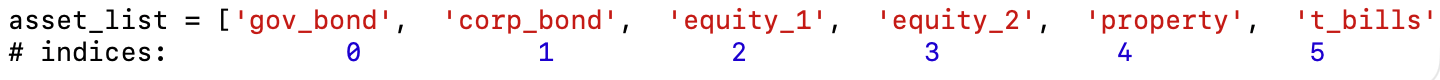

We were passign corp bond and equity 1 to scr_eq which should have equity1 and equity2

That's the correct one 

	•	A_opt[1] = corp_bond
	•	A_opt[2] = equity_1
	•	A_opt[3] = equity_2


Changing the mat alloc function , we need 4 row instead of three(as I changed the allocation limits data):

	•	Row 1: gov, row 2: illiquid (eq1+eq2+prop), row 3: t-bills, row 4: corporates.

Changing gamma ( in the new version)

before for gamma in np.arange(0.0000001, 0.00001, 0.0000001):

a very narrow and very small range, with tiny step increments (1e-7).

That range made the risk penalty negligible

it will be replaced with 

gammas = np.logspace(-8, 0, 40)

This ensures the optimization explores:

	•	Very low risk aversion (almost pure return maximization)

	•	Medium values (balanced risk/return)
    
	•	Very high risk aversion (SCR minimization)

In [61]:
## INVESTMENT CONSTRAINTS

# 1. Budget (Sum of all assets equal total assets)
A_mat = np.zeros((1, 10))   # 1 constraint, 10 variables
A_mat[0, :6] = 1            # only sum the asset positions

budget_constraint = LinearConstraint(A_mat, [asset_total], [asset_total])

# 2. Allocation limits 
# A_mat_alloc = np.zeros((3, 10))  # 3 constraints, 10 variables

# # Government Bonds
# A_mat_alloc[0, 0] = 1
# # Illiquid Assets (corp bonds + equities + property)
# A_mat_alloc[1, [1, 2, 3, 4]] = 1
# # Treasury Bills
# A_mat_alloc[2, 5] = 1

# alloc_constraint = LinearConstraint(
#     A_mat_alloc,
#     lb=allocation_limits["min_weight"].values * asset_total,  # lower bounds
#     ub=allocation_limits["max_weight"].values * asset_total   # upper bounds
#)

# 2. Allocation limits 
A_mat_alloc = np.zeros((4, 10))  # 4 constraints, 10 variables

# Row 0: Government Bonds
A_mat_alloc[0, 0] = 1

# Row 1: Illiquid Assets = equity_1 + equity_2 + property
A_mat_alloc[1, [2, 3, 4]] = 1

# Row 2: Treasury Bills
A_mat_alloc[2, 5] = 1

# Row 3: Corporate Bonds
A_mat_alloc[3, 1] = 1

alloc_constraint = LinearConstraint(
    A_mat_alloc,
    lb = allocation_limits["min_weight"].values * asset_total,
    ub = allocation_limits["max_weight"].values * asset_total,
)

# 3. Non-negativity constraints (no short-selling, no negative capital requirements)
nonneg_constraint = LinearConstraint(np.eye(10), lb=np.zeros(10), ub=np.full(10, np.inf))

constraints = [
    int_up_constraint,
    int_down_constraint,
    eq_constraint,
    prop_constraint,
    spread_constraint,
    budget_constraint,
    alloc_constraint,
    # nonneg_constraint
]

A0 = np.ones(6) * (asset_total / 6)   # evenly split total asset value
s0 = np.ones(4) * 0.1                 # small positive SCRs (avoid zero division)
x0 = np.concatenate([A0, s0])

r = initial_asset['asset_ret'].values

opt_results = []

for gamma in np.arange(0.0000001, 0.00001, 0.0000001):

    bounds = Bounds(
        lb=np.zeros(10),          # 10 variables, all ≥ 0
        ub=np.full(10, np.inf)    # no upper limit
    )

    # Solve with downward correlation matrix
    res_down = minimize(
        objective,
        x0,
        args=(r, gamma, corr_downward.values),
        constraints=constraints,
        method='SLSQP',
        bounds=bounds
    )

    # Solve with upward correlation matrix
    res_up = minimize(
        objective,
        x0,
        args=(r, gamma, corr_upward.values),
        constraints=constraints,
        method='SLSQP',
        bounds=bounds
    )

    # Pick the better solution (higher objective => lower 'fun' since we minimize the negative)
    if res_down.fun < res_up.fun:
        best_res = res_down
        R_used = corr_downward.values
        panel_penalty = "Interest_DOWN"
    else:
        best_res = res_up
        R_used = corr_upward.values
        panel_penalty = "Interest_UP"

    A_opt = best_res.x[:6]
    s_opt = best_res.x[6:]

    port_return = (A_opt @ r) / asset_total
    risk_term = s_opt @ R_used @ s_opt

    # Calculate SCR (new way)
    scr_interest = scr_interest_rate(
        A_opt,
        initial_asset['asset_dur'],
        liab_value,
        liab_duration,
        int_down_param,
        int_up_param
    )

    # Correct mapping of optimized assets:
    # index 2 = equity_1, index 3 = equity_2
    A_eq1 = A_opt[2]
    A_eq2 = A_opt[3]
    A_corp = A_opt[1]
    A_prop = A_opt[4]

    scr_equity = scr_eq(A_eq1, A_eq2, equity_1_param, equity_2_param, rho)
    scr_property = A_prop * prop_params
    scr_spread = A_corp * spread_params

    scr_total = aggregate_market_scr(
        scr_interest,
        scr_equity,
        scr_property,
        scr_spread,
        corr_downward,
        corr_upward
    )['SCR_market_final']

    solvency_ratio = (asset_total - liab_value[0]) / scr_total

    opt_results.append({
        "gamma": gamma,
        "objective": -best_res.fun,
        "return": port_return,
        "A_opt": A_opt,
        "s_opt": s_opt,
        "solvency": solvency_ratio,
        "risk_term": risk_term,
        "return_term": A_opt @ r,
        "SCR": scr_total,
        "panel_penalty": panel_penalty,
    })

 # Calculate SCR (old way)

    # scr_interest = scr_interest_rate(A_opt, initial_asset['asset_dur'], 
    #                                  liab_value, liab_duration, int_down_param, int_up_param)
    
    # scr_equity = scr_eq(A_opt[1], A_opt[2], equity_1_param, equity_2_param, rho)

    # scr_property = A_opt[4] * prop_params

    # scr_spread = A_opt[1] * spread_params

    # calculate SRC (new way)

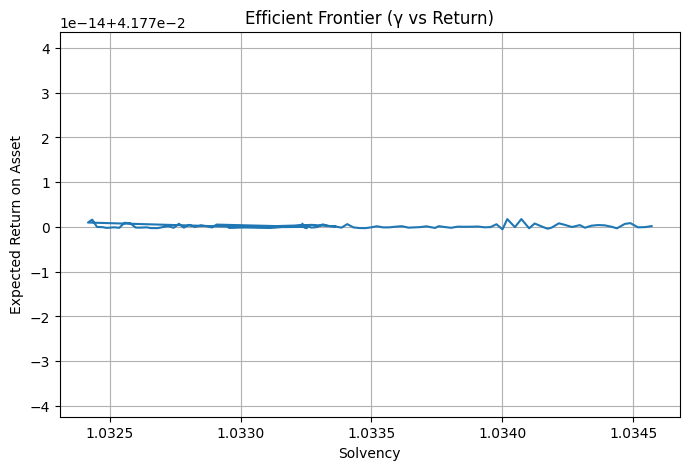

In [62]:

opt_df = pd.DataFrame(opt_results)


plt.figure(figsize=(8,5))
plt.plot(opt_df["solvency"], opt_df["return"])
plt.xlabel("Solvency")
plt.ylabel("Expected Return on Asset")
plt.title("Efficient Frontier (γ vs Return)")
plt.grid(True)
plt.show()

In [54]:
opt_df

,gamma,objective,return,A_opt,s_opt,solvency,risk_term,return_term,SCR
0,1.000000e-07,54.625434,0.033053,"[1239.5250000003928, 97.15485325499004, 73.811...","[22.141370130096345, 61.92432552312321, 22.986...",2.333619,10356.590060,54.626469,97.916587
1,2.000000e-07,56.664184,0.034288,"[1239.525, 3.902268001388471e-12, 125.62488232...","[26.51333849999981, 92.50582658153034, 29.5112...",1.813819,17461.213138,56.667676,125.977303
2,3.000000e-07,56.663628,0.034289,"[1239.525, 9.728986498123326e-11, 182.76065922...","[26.513343803367828, 86.9165265926192, 28.9653...",1.855873,20254.491775,56.669705,123.122645
3,4.000000e-07,54.614516,0.033048,"[1239.5250000000185, 97.50326215126259, 73.641...","[22.12569169191798, 61.78218666388867, 22.9804...",2.336371,10325.637592,54.618646,97.801268
4,5.000000e-07,57.579789,0.034850,"[1239.525, 5.866096058918292e-12, 172.67570033...","[26.51333849999972, 144.69703545018024, 23.067...",1.519106,33611.490897,57.596595,150.417453
...,...,...,...,...,...,...,...,...,...
94,9.500000e-06,54.757241,0.033196,"[1239.524999999999, 86.5956787263522, 79.13951...","[22.616532930655556, 66.3269659968396, 23.1779...",2.253711,11153.667676,54.863200,101.388321
95,9.600000e-06,56.624861,0.034371,"[1239.5250000000262, 2.3455430707964684e-08, 1...","[26.51333849899377, 101.2800514611871, 24.7633...",1.753226,18677.713015,56.804167,130.331144
96,9.700000e-06,54.516938,0.033047,"[1239.5249999982486, 97.57674194717954, 73.609...","[22.12238511107502, 61.75420970293825, 22.9780...",2.336933,10319.202195,54.617034,97.777740
97,9.800000e-06,54.515843,0.033047,"[1239.5249999945163, 97.57722700896825, 73.604...","[22.12472597855898, 61.75179078597732, 22.9816...",2.336957,10320.156765,54.616980,97.776727


In [55]:
opt_df['s_opt']

0     [22.141370130096345, 61.92432552312321, 22.986...
1     [26.51333849999981, 92.50582658153034, 29.5112...
2     [26.513343803367828, 86.9165265926192, 28.9653...
3     [22.12569169191798, 61.78218666388867, 22.9804...
4     [26.51333849999972, 144.69703545018024, 23.067...
                            ...                        
94    [22.616532930655556, 66.3269659968396, 23.1779...
95    [26.51333849899377, 101.2800514611871, 24.7633...
96    [22.12238511107502, 61.75420970293825, 22.9780...
97    [22.12472597855898, 61.75179078597732, 22.9816...
98    [22.12253854588614, 61.75356627058284, 22.9792...
Name: s_opt, Length: 99, dtype: object